In [1]:
#!pip install -U aeon
#!pip install aeon[all_extras]
import warnings
import pandas as pd
import numpy as np
from aeon.datasets import load_airline
from aeon.forecasting.arima import ARIMA
from matplotlib import pyplot as plt
from aeon.forecasting.arima import AutoARIMA
from aeon.forecasting.sarimax import SARIMAX
# from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
warnings.filterwarnings("ignore")
%matplotlib inline

/home/anp/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


Metrics

In [2]:
def rmse(y_true, y_pred):
  return np.sqrt(mse(y_true, y_pred))

def pocid(y_true, y_pred):
    n = len(y_true)
    D = [1 if (y_pred[i] - y_pred[i-1]) * (y_true[i] - y_true[i-1]) > 0 else 0 for i in range(1, n)]
    POCID = 100 * np.sum(D) / n
    return POCID

def mcpm(rmse_result, mape_result, pocid_result):
  er_result = 100 - pocid_result

  A1 = (rmse_result * mape_result * np.sin((2*np.pi)/3))/2
  A2 = (mape_result * er_result * np.sin((2*np.pi)/3))/2
  A3 = (er_result * rmse_result * np.sin((2*np.pi)/3))/2
  total = A1 + A2 + A3
  return total

Normalization

In [3]:
def znorm(x):
  x_znorm = (x - np.mean(x)) / np.std(x)
  return x_znorm

def znorm_reverse(x, mean_x, std_x):
  x_denormalized = (np.array(x) * std_x) + mean_x
  return x_denormalized

def get_stats_norm(series, horizon, window):
  last_subsequence = series[-(horizon+window):-horizon].values
  last_mean = np.mean(last_subsequence)
  last_std = np.std(last_subsequence)
  return last_mean, last_std

Auxiliary Functions

In [4]:
# Em geral, considera-se um tamanho de janela capaz de capturar um ciclo dos dados
# Por exemplo, 12 observações no caso dos dados com frequência mensal
def rolling_window(series, window):
  data = []
  for i in range(len(series)-window):
    example = znorm(np.array(series[i:i+window+1]))
    data.append(example)
  df = pd.DataFrame(data)
  return df


def rolling_window_stats(series, window):
    data = []
    for i in range(len(series)-window):
      example = znorm(np.array(series.iloc[i:i+window+1]))
      data.append(pd.Series(example)) 
    result_series = pd.concat(data, ignore_index=True)
    return result_series

# Para predição de vendas por UF (mensal), será considerado horizon = 12
# Para predição de vendas por município (anual), será considerado horizon = 1
def train_test_split(data, horizon):
  X = data.iloc[:,:-1] # features
  y = data.iloc[:,-1] # target

  X_train = X[:-horizon] # features train
  X_test =  X[-horizon:] # features test

  y_train = y[:-horizon] # target train
  y_test = y[-horizon:] # target test
  return X_train, X_test, y_train, y_test

def train_test_stats(data, horizon):
  # data = pd.Series(np.diff(data).flatten())
  # print(pd.Series(data))
  train, test = data[:-horizon], data[-horizon:]
  return train, test

def recursive_multistep_forecasting(X_test, model, horizon):
  # example é composto pelas últimas observações vistas
  # na prática, é o primeiro exemplo do conjunto de teste
  example = X_test.iloc[0].values.reshape(1,-1)

  preds = []
  for i in range(horizon):
    pred = model.predict(example)[0]
    preds.append(pred)

    # Descartar o valor da primeira posição do vetor de características
    example = example[:,1:]

    # Adicionar o valor predito na última posição do vetor de características
    example = np.append(example, pred)
    example = example.reshape(1,-1)
  return preds

def recursive_forecasting_stats(data, model, horizon):
  predictions = []
  lista = list(data)
  # print(lista)
  for _ in range(horizon):    
    next_prediction = model.predict(fh=1).iloc[0]

    lista.append(next_prediction)
    serie = pd.Series(lista[1:])
    model.fit(serie)       
    predictions.append(next_prediction)

  return pd.Series(predictions)


In [5]:
from mango import scheduler, Tuner

def arima_objective_function(args_list):
    global data_values
    global validation
    global horizon
    params_evaluated = []

    results = []
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            # ps,ds,qs,ss = params['ps'],params['ds'], params['qs'], params['ss']
            trend = params['trend']
            
            model = ARIMA(order=(p,d,q), 
                          trend = trend, 
                          #seasonal_order=(ps,ds,qs,ss),
                          suppress_warnings=True
                          )
            model.fit(data_values)
            predictions = recursive_forecasting_stats(data_values, model, horizon)
            # mse = mean_squared_error(data_values, predictions.fittedvalues)   
            rmse_result = rmse(validation, predictions)
            mape_result = mape(validation, predictions)
            pocid_result = pocid(list(validation), predictions)
            mcpm_result = mcpm(rmse_result, mape_result, pocid_result)

            params_evaluated.append(params)
            results.append(mcpm_result)
        except:
            params_evaluated.append(params)
            results.append(1e5)

    return params_evaluated, results

def sarimax_objective_function(args_list):
    global data_values
    global validation
    global horizon
    params_evaluated = []

    results = []
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            ps,ds,qs,ss = params['ps'],params['ds'], params['qs'], params['ss']
            
            trend = params['trend']
            
            model = SARIMAX(order=(p,d,q), trend = trend, seasonal_order=(ps,ds,qs,ss))
            model.fit(data_values)
            predictions = recursive_forecasting_stats(data_values, model, horizon)
            # mse = mean_squared_error(data_values, predictions.fittedvalues)   
            rmse_result = rmse(validation, predictions)
            mape_result = mape(validation, predictions)
            pocid_result = pocid(list(validation), predictions)
            mcpm_result = mcpm(rmse_result, mape_result, pocid_result)

            params_evaluated.append(params)
            results.append(mcpm_result)
        except:
            params_evaluated.append(params)
            results.append(1e5)

    return params_evaluated, results

In [27]:
df = pd.read_csv("./uf/oleodiesel/mensal_pr_oleodiesel.csv", header=0, sep=";")


Text(0, 0.5, 'Volume em $M^3$')

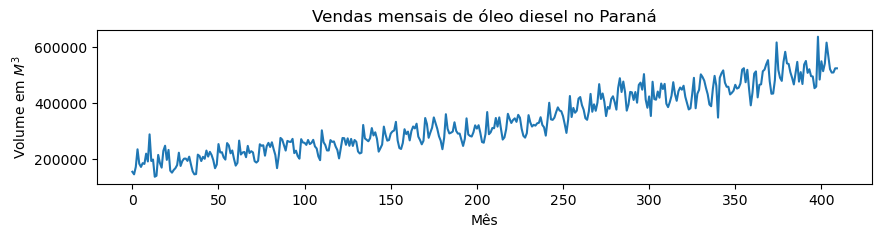

In [7]:
series = df["m3"]

plt.figure(figsize=(10,2))
plt.title('Vendas mensais de óleo diesel no Paraná')
plt.plot(series)
plt.xlabel('Mês')
plt.ylabel('Volume em $M^3$')

In [28]:
horizon = 12
window = 24
data = rolling_window_stats(df['m3'], 12)
train, test = train_test_stats(data, horizon)
train_data, validation_data = train_test_stats(train, horizon)

In [ ]:
param_space_arima = dict(p = range(0, 30),
                   d = range(0, 30),
                   q = range(0, 30),
                   trend = ['n', 'c', 't', 'ct'],
                #    ps = range(0, 30),
                #    ds = range(0, 30),
                #    qs = range(0, 30),
                #    ss = range(0, 52)
                  )
conf_Dict = dict()
conf_Dict['num_iteration'] = 10
data_values = train_data
validation = validation_data
tuner = Tuner(param_space_arima, arima_objective_function, conf_Dict)
results_arima = tuner.minimize()
print('best parameters:', results_arima['best_params'])
print('best loss:', results_arima['best_objective'])
with open("results.txt", "a") as arquivo:
    arquivo.write('----- ARIMA ------\n')
    arquivo.write(f"best parameters:{results_arima['best_params']}\n")
    arquivo.write(f"best loss: ${results_arima['best_objective']}\n")

In [ ]:
param_space_sarimax = dict(p = range(0, 30),
                   d = range(0, 30),
                   q = range(0, 30),
                   trend = ['n', 'c', 't', 'ct'],
                   ps = range(0, 30),
                   ds = range(0, 30),
                   qs = range(0, 30),
                   ss = range(0, 52)
                  )
conf_Dict = dict()
conf_Dict['num_iteration'] = 200
data_values = train_data
validation = validation_data
tuner = Tuner(param_space_sarimax, sarimax_objective_function, conf_Dict)
results_sarimax = tuner.minimize()
print('best parameters:', results_sarimax['best_params'])
print('best loss:', results_sarimax['best_objective'])
with open("results.txt", "a") as arquivo:
    arquivo.write('----- SARIMAX ------')
    arquivo.write(f"best parameters:{results_sarimax['best_params']}\n")
    arquivo.write(f"best loss: ${results_sarimax['best_objective']}\n")

In [12]:
order_arima = (results_arima['best_params']['p'], results_arima['best_params']['d'], results_arima['best_params']['q'])
model_arima = ARIMA(order=order_arima, trend = results_arima['best_params']['trend'], suppress_warnings=True)
model_arima.fit(train)

# order_sarimax = (results_sarimax['best_params']['p'], results_sarimax['best_params']['d'], results_sarimax['best_params']['q'])
# seasonal_order_sarimax = (results_sarimax['best_params']['ps'], results_sarimax['best_params']['ds'], results_sarimax['best_params']['qs'], results_sarimax['best_params']['ss'])


# model_sarimax = SARIMAX(order=order_sari---max, seasonal_order=seasonal_order_sarimax, trend = results_sarimax['best_params']['trend'])
# model_sarimax.fit(train)
# model_auto = AutoARIMA(suppress_warnings=True)
# model_auto.fit(train)

ARIMA(order=(20, 8, 18), suppress_warnings=True, trend='n')

In [32]:
model_arima2 = ARIMA(order=(1,1,1), trend = results_arima['best_params']['trend'], suppress_warnings=True)
model_arima2.fit(train)

ARIMA(order=(1, 1, 1), suppress_warnings=True, trend='n')

In [33]:
predictions_arima = recursive_forecasting_stats(train, model_arima2, horizon)
# predictions_sarimax = recursive_forecasting_stats(train, model_sarimax, horizon)


---------- ARIMA -----------------
RMSE: 1.0074915024290514
MAPE: 1.0154220339608324
POCID: 41.666666666666664
MCPM: 51.53990785368666


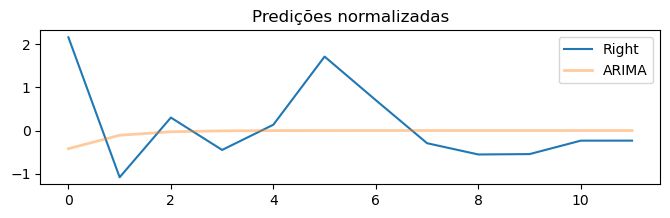

In [34]:
rmse_result = rmse(list(test), predictions_arima)
mape_result = mape(list(test), predictions_arima)
pocid_result = pocid(list(test), predictions_arima)
mcpm_result = mcpm(rmse_result, mape_result, pocid_result)
print('---------- ARIMA -----------------')
print(f'RMSE: {rmse_result}')
print(f'MAPE: {mape_result}')
print(f'POCID: {pocid_result}')
print(f'MCPM: {mcpm_result}')
# rmse_result = rmse(list(test), predictions_sarimax)
# mape_result = mape(list(test), predictions_sarimax)
# pocid_result = pocid(list(test), predictions_sarimax)
# mcpm_result = mcpm(rmse_result, mape_result, pocid_result)
# print('---------- SARIMAX -----------------')
# print(f'RMSE: {rmse_result}')
# print(f'MAPE: {mape_result}')
# print(f'POCID: {pocid_result}')
# print(f'MCPM: {mcpm_result}')

test.index = range(0,12)

plt.figure(figsize=(8,2))
plt.title('Predições normalizadas')
# plt.plot(train, label='Normal')
plt.plot(test, label='Right')
# plt.plot(predictions_sarimax, linewidth=2, alpha=0.4, label='SARIMAX')
plt.plot(predictions_arima, linewidth=2, alpha=0.4, label='ARIMA')
# plt.plot(predictions_auto, label='AutoArima')
plt.legend()